**Table of contents**<a id='toc0_'></a>    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## Data preprocessing

> Experiments with a preprocessing pipeline.

### Setup


In [8]:
#| default_exp preprocessing
#| export
import pathlib
import random

import matplotlib.pyplot as plt
from torchvision.transforms import transforms
import torchvision.transforms.functional as TF

from csgo_clips_autotrim.segmentation import EliminationEventsDataset, box_to_mask, show_mask

In [9]:
DATA_DIR = pathlib.Path('/data/autotrim/datasets/')
FRAMES_DATA_DIR = DATA_DIR / 'frames'
COCO_DATASET_DIR = DATA_DIR / 'frames-annotated-coco'
ANNOTATIONS_PATH = COCO_DATASET_DIR / 'result.json'
dataset = EliminationEventsDataset(annotation_file_path=ANNOTATIONS_PATH)

loading annotations into memory...
Done (t=0.21s)
creating index...
index created!


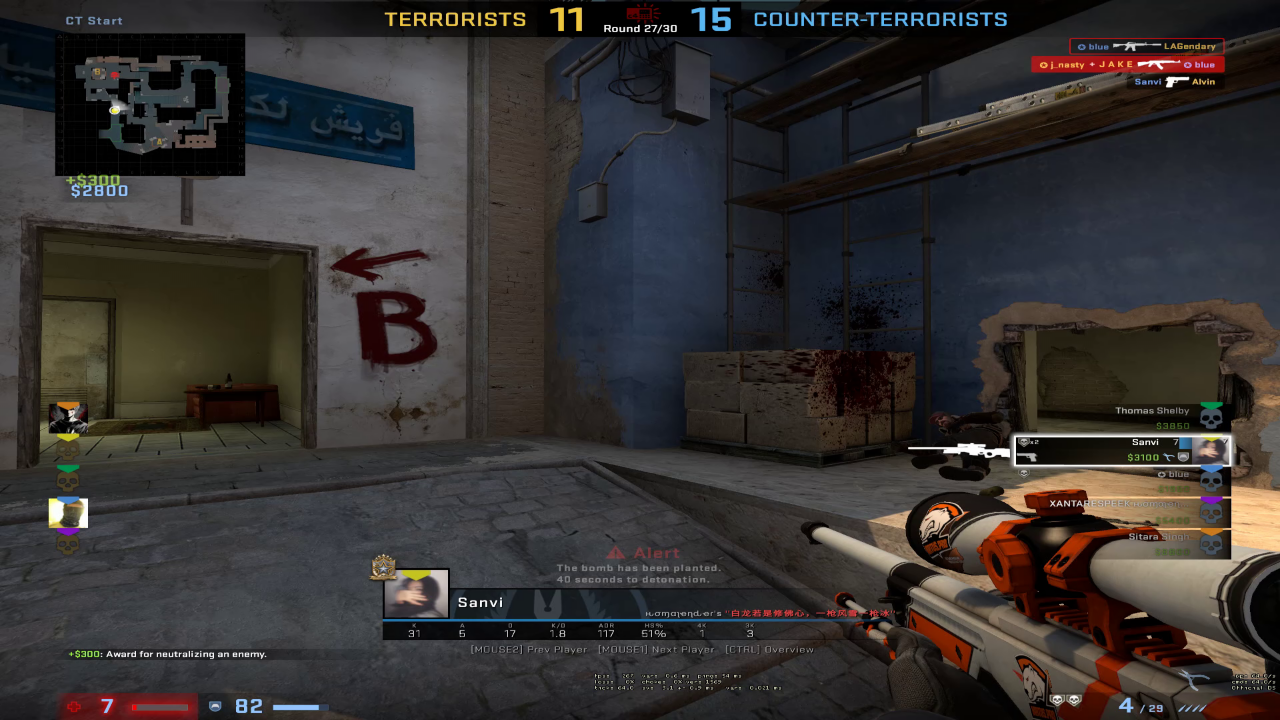

In [10]:
test_frame, annotations = random.choice(dataset)

test_frame

### Preprocessing options

1. Crop (top right)
2. Thresholding
3. Edge detection

In [11]:
# |export
# Define the custom transformation for top right quadrant
class TopRightQuadrant(object):
    def __call__(self, entry):
        img, targets = entry
        width, height = img.size
        img = img.crop((width // 2, 0, width, height // 2))

        # Adjust target bounding box coordinates
        for box in targets['boxes']:
            # xmin, ymin, xmax, ymax = box
            # # Only need to adjust the x coordinates.
            box[[0, 2]] -= width / 2

        return img, targets

class ImageVisTransform:
    def __init__(self, sharpness=2):
        self.sharpness = sharpness
    
    def __call__(self, x):
        img, targets = x
        return TF.autocontrast(TF.adjust_sharpness(img, self.sharpness)), targets

class ImageToTensor:
    def __call__(self, x):
        img, targets = x
        return TF.to_tensor(img), targets

class Grayscale:
    def __call__(self, x):
        img, targets = x
        return TF.to_grayscale(img), targets

In [12]:
# Define the preprocessing transformations
preprocess = transforms.Compose([
    TopRightQuadrant(),  # Use the top right quadrant only
    ImageVisTransform(1)
])

In [13]:
dataset = EliminationEventsDataset(annotation_file_path=ANNOTATIONS_PATH, transforms=preprocess)

loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


5


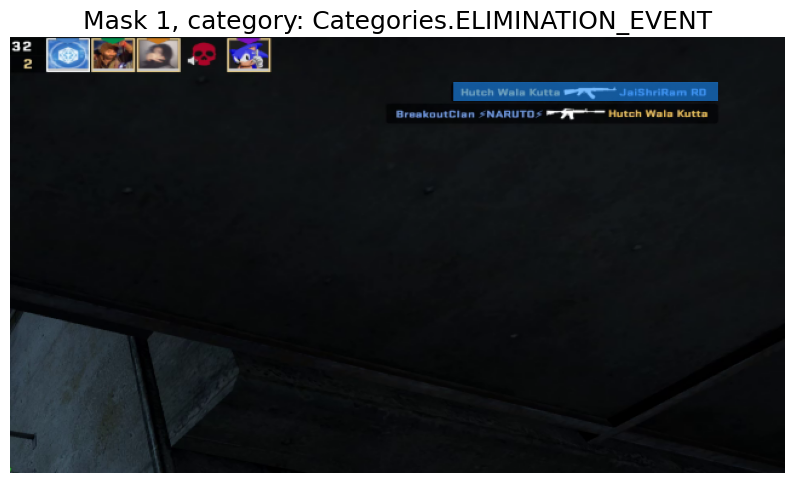

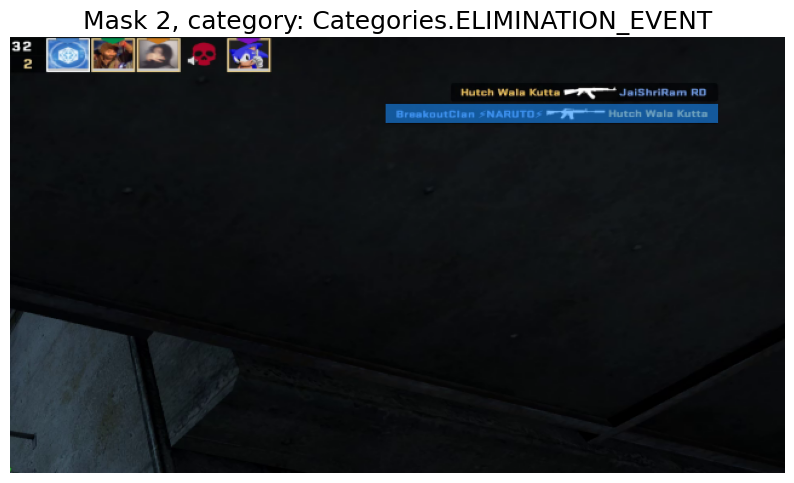

In [14]:
sample = random.choice(dataset)
img, anns = sample

print(len(anns))

for i in range(len(anns['boxes'])):
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    mask = box_to_mask(anns['boxes'][i], img.height, img.width)
    show_mask(mask, plt.gca())
    category = EliminationEventsDataset.Categories(anns['labels'][i].numpy())
    plt.title(f"Mask {i+1}, category: {category}", fontsize=18)
    plt.axis('off')
    plt.show()  

### Preprocessing config